# Data Mining & ML project

## Dépendances

In [1]:
!pip install sparqlwrapper pandas numpy scikit-learn opencv-python unidecode ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.2 MB/s eta 0:00:00


## Imports

In [2]:
import os
import re
import sys
import ast
import json
import time
import shutil
import requests
import webcolors
import random
from datetime import datetime
import pandas as pd
import numpy as np
from PIL import Image, ExifTags, TiffImagePlugin
from PIL.ExifTags import TAGS
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import matplotlib.pyplot as plt
from urllib.parse import unquote, urlparse
from unidecode import unidecode
import unicodedata
import ipywidgets as widgets
from ipywidgets import GridspecLayout, Image, interact, Label, HTML, Output
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/gdrive') # data persistance

Mounted at /content/gdrive


## Constantes

In [4]:
ENDPOINT_WIKIDATA_URL = "https://query.wikidata.org/sparql"
IMAGES_DIR = "/content/gdrive/MyDrive/DataMiningResources/images"
IMAGES_METADATA_DIR = "/content/gdrive/MyDrive/DataMiningResources/metadata"
DATASETS_DIR = "/content/gdrive/MyDrive/DataMiningResources/datasets"

In [ ]:
def empty_directory(directory):
  for file in os.listdir(directory):
    filepath = os.path.join(directory, file)
    try:
      if os.path.isfile(filepath):
        os.remove(filepath)
    except Exception as e:
      print(f"Erreur lors de la suppression de {filepath}: {e}")

In [ ]:
# Empty directories before notebook execution

#empty_directory(IMAGES_DIR)
#empty_directory(IMAGES_METADATA_DIR)

#assert len(os.listdir(IMAGES_DIR)) == 0
#assert len(os.listdir(IMAGES_METADATA_DIR)) == 0

## Collecte de données (ne pas relancer les cellules !)

In [ ]:
def get_results(endpoint_url, query):
  """
  Get SparQL query results in a JSON array

  Parameters:
  endpoint_url: The API endpoint URL
  query: The query string to execute

  Returns:
  array: JSON array of the query result
  """
  user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1],)
  sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  return sparql.query().convert()

In [ ]:
# Get a set of paintings

query = """SELECT DISTINCT ?painting ?paintingLabel ?creator ?creatorLabel ?country ?countryLabel ?genre ?genreLabel (GROUP_CONCAT(DISTINCT ?depictsLabel; separator=", ") as ?depictsLabels) ?image WHERE {
  ?painting wdt:P31 wd:Q3305213;
    wdt:P495  ?country;
    wdt:P170  ?creator;
    wdt:P136  ?genre;
    wdt:P180  ?depicts;
    wdt:P18   ?image.

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }

  # Retrieve labels for depicts entities
  OPTIONAL {
    ?depicts rdfs:label ?depictsLabel.
    FILTER(LANG(?depictsLabel) = "en")
  }
}
GROUP BY ?painting ?paintingLabel ?creator ?creatorLabel ?country ?countryLabel ?genre ?genreLabel ?image
LIMIT 1400
"""

array = []
results = get_results(ENDPOINT_WIKIDATA_URL, query)

for result in results["results"]["bindings"]:
  array.append(
    (
      result["paintingLabel"]["value"],
      result["creatorLabel"]["value"],
      result["countryLabel"]["value"],
      result["genreLabel"]["value"],
      result["depictsLabels"]["value"],
      result["image"]["value"],
    )
  )

paintings_df = pd.DataFrame(array, columns=["painting", "creator", "country", "genre", "depicts", "image"])
paintings_df = paintings_df.astype(
    dtype={"painting": "<U200", "creator": "<U200", "country": "<U200", "genre": "<U200", "depicts": "<U200", "image": "<U200"}
)
paintings_df

,painting,creator,country,genre,depicts,image
0,Mary Elizabeth Snow,http://www.wikidata.org/.well-known/genid/a32e...,United States of America,portrait,"woman, portrait",http://commons.wikimedia.org/wiki/Special:File...
1,Portrait of a Gentleman,Emanuel Leutze,United States of America,portrait,"man, portrait",http://commons.wikimedia.org/wiki/Special:File...
2,Portrait of Louis-André Boicervoise,Louise Eudes de Guimard,France,portrait,Louis-André Boicervoise,http://commons.wikimedia.org/wiki/Special:File...
3,Pompeii,Robert Seldon Duncanson,United States of America,landscape art,"Mount Vesuvius, sky, column, cloud, mountain, ...",http://commons.wikimedia.org/wiki/Special:File...
4,Seacoast,Edward Moran,United States of America,marine art,"rock, ocean, stairs, cliff",http://commons.wikimedia.org/wiki/Special:File...
...,...,...,...,...,...,...
1395,Portrait of the Artist,George Augustus Baker,United States of America,self-portrait,George Augustus Baker,http://commons.wikimedia.org/wiki/Special:File...
1396,"Mount Vesuvius from Marina Grande, Capri",Sanford Robinson Gifford,United States of America,landscape art,"sky, Mount Vesuvius, cloud, boat, smoke, Capri...",http://commons.wikimedia.org/wiki/Special:File...
1397,Shakyamuni Triad with the Sixteen Protectors o...,http://www.wikidata.org/.well-known/genid/74d5...,Japan,religious art,"lion, Buddha, elephant, Gautam Buddha, deity, ...",http://commons.wikimedia.org/wiki/Special:File...
1398,Indian Summer on the Hudson River,Albert Bierstadt,United States of America,landscape art,"Hudson River, indian summer",http://commons.wikimedia.org/wiki/Special:File...


In [ ]:
def check_image_extension(url):
    valid_extensions = ['png', 'jpg', 'jpeg']
    extension = os.path.basename(url.split('.')[-1].lower())
    return extension in valid_extensions

paintings_df['valid_extension'] = paintings_df['image'].apply(check_image_extension)

paintings_df = paintings_df[paintings_df['valid_extension']]
paintings_df.drop(columns=['valid_extension'], inplace=True)
paintings_df

<ipython-input-12-a81b0f95795f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paintings_df['valid_extension'] = paintings_df['image'].apply(check_image_extension)


,painting,creator,country,genre,depicts,image
0,Mary Elizabeth Snow,http://www.wikidata.org/.well-known/genid/a32e...,United States of America,portrait,"woman, portrait",http://commons.wikimedia.org/wiki/Special:File...
1,Portrait of a Gentleman,Emanuel Leutze,United States of America,portrait,"man, portrait",http://commons.wikimedia.org/wiki/Special:File...
2,Portrait of Louis-André Boicervoise,Louise Eudes de Guimard,France,portrait,Louis-André Boicervoise,http://commons.wikimedia.org/wiki/Special:File...
3,Pompeii,Robert Seldon Duncanson,United States of America,landscape art,"Mount Vesuvius, sky, column, cloud, mountain, ...",http://commons.wikimedia.org/wiki/Special:File...
4,Seacoast,Edward Moran,United States of America,marine art,"rock, ocean, stairs, cliff",http://commons.wikimedia.org/wiki/Special:File...
...,...,...,...,...,...,...
1395,Portrait of the Artist,George Augustus Baker,United States of America,self-portrait,George Augustus Baker,http://commons.wikimedia.org/wiki/Special:File...
1396,"Mount Vesuvius from Marina Grande, Capri",Sanford Robinson Gifford,United States of America,landscape art,"sky, Mount Vesuvius, cloud, boat, smoke, Capri...",http://commons.wikimedia.org/wiki/Special:File...
1397,Shakyamuni Triad with the Sixteen Protectors o...,http://www.wikidata.org/.well-known/genid/74d5...,Japan,religious art,"lion, Buddha, elephant, Gautam Buddha, deity, ...",http://commons.wikimedia.org/wiki/Special:File...
1398,Indian Summer on the Hudson River,Albert Bierstadt,United States of America,landscape art,"Hudson River, indian summer",http://commons.wikimedia.org/wiki/Special:File...


In [ ]:
def generate_unique_filename(extension):
  """
  Generate a unique filename based on the current timestamp
  """
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
  unique_filename = f"image_{timestamp}.{extension}"
  return unique_filename

In [ ]:
def download_image(url):
  """
  Downloading an image from URL
  """
  headers = {"User-Agent": "Mozilla/5.0"}
  request = requests.get(url, allow_redirects=True, headers=headers, stream=True)

  if request.status_code == 200:
    if not os.path.exists(IMAGES_DIR):
      os.makedirs(IMAGES_DIR)

    extension = url.split(".")[-1]
    file_name = generate_unique_filename(extension)
    file_path = os.path.join(IMAGES_DIR, file_name)

    with open(file_path, "wb") as image:
      request.raw.decode_content = True
      shutil.copyfileobj(request.raw, image)

    return request.status_code, file_name
  else:
    return request.status_code, None

In [ ]:
# download paintings images

paintings_df[['status', 'image_filename']] = paintings_df['image'].apply(download_image).apply(pd.Series)
paintings_df = paintings_df.dropna(subset=['image_filename'])
paintings_df = paintings_df.drop(columns=['status'])
paintings_df

,painting,creator,country,genre,depicts,image,image_filename
0,Mary Elizabeth Snow,http://www.wikidata.org/.well-known/genid/a32e...,United States of America,portrait,"woman, portrait",http://commons.wikimedia.org/wiki/Special:File...,image_20240311_195428_030942.jpg
1,Portrait of a Gentleman,Emanuel Leutze,United States of America,portrait,"man, portrait",http://commons.wikimedia.org/wiki/Special:File...,image_20240311_195428_620449.jpg
2,Portrait of Louis-André Boicervoise,Louise Eudes de Guimard,France,portrait,Louis-André Boicervoise,http://commons.wikimedia.org/wiki/Special:File...,image_20240311_195429_274962.jpg
3,Pompeii,Robert Seldon Duncanson,United States of America,landscape art,"Mount Vesuvius, sky, column, cloud, mountain, ...",http://commons.wikimedia.org/wiki/Special:File...,image_20240311_195429_838509.jpg
4,Seacoast,Edward Moran,United States of America,marine art,"rock, ocean, stairs, cliff",http://commons.wikimedia.org/wiki/Special:File...,image_20240311_195430_444526.jpg
...,...,...,...,...,...,...,...
1386,Portrait of the Artist,George Augustus Baker,United States of America,self-portrait,George Augustus Baker,http://commons.wikimedia.org/wiki/Special:File...,image_20240311_200843_346216.jpg
1387,"Mount Vesuvius from Marina Grande, Capri",Sanford Robinson Gifford,United States of America,landscape art,"sky, Mount Vesuvius, cloud, boat, smoke, Capri...",http://commons.wikimedia.org/wiki/Special:File...,image_20240311_200843_731883.jpg
1388,Shakyamuni Triad with the Sixteen Protectors o...,http://www.wikidata.org/.well-known/genid/74d5...,Japan,religious art,"lion, Buddha, elephant, Gautam Buddha, deity, ...",http://commons.wikimedia.org/wiki/Special:File...,image_20240311_200844_100465.jpg
1389,Indian Summer on the Hudson River,Albert Bierstadt,United States of America,landscape art,"Hudson River, indian summer",http://commons.wikimedia.org/wiki/Special:File...,image_20240311_200844_613061.jpg


In [ ]:
def cast(v):
  """
  Cast a given value according to its format.

  See https://github.com/python-pillow/Pillow/issues/6199

  Parameters:
  v: The input value

  Returns:
  casted: The casted value
  """
  if isinstance(v, TiffImagePlugin.IFDRational):
    return float(v)
  elif hasattr(v, '__divmod__'):
    return v
  elif isinstance(v, tuple):
    return tuple(cast(t) for t in v)
  elif isinstance(v, bytes):
    return v.decode(errors="replace")
  elif isinstance(v, dict):
    for kk, vv in v.items():
        v[kk] = cast(vv)
    return v
  else: return v

In [ ]:
import PIL

def extract_image_exif_metadata(image_path, exif_filters=None):
  """
  Extracts Exif metadata from an image file

  Parameters:
  image_path: The path to the image file
  exif_filters: Exif filters that you want to apply during the extraction

  Returns:
  dict: A dictionary containing metadata extracted from the image file
  """
  try:
    with PIL.Image.open(image_path) as img:
      metadata = {}
      exif_data = img._getexif()

      if exif_data:
        for tag, value in exif_data.items():
          if tag in TAGS:
            tag_name = TAGS.get(tag)
            if exif_filters is None or tag_name in exif_filters:
              metadata[tag_name] = cast(value)

      metadata['filename'] = os.path.basename(image_path)
      metadata['size'] = img.size
      metadata['format'] = img.format
      metadata['mode'] = img.mode

      return metadata
  except Exception as e:
    print(f"Error extracting metadata from {image_path}: {e}")
    return {}

In [ ]:
def save_metadata_to_json(metadata, json_file_path):
  """
  Save metadata into a JSON file

  Parameters:
  metadata: A dictionnary containing the data you want to store
  json_file: The JSON filepath in which you want to store the data
  """
  try:
    if not os.path.exists(os.path.dirname(json_file_path)):
      os.makedirs(os.path.dirname(json_file_path))

    with open(json_file_path, 'w', encoding='utf-8') as f:
      json.dump(metadata, f, ensure_ascii=False)
  except Exception as e:
    print(f"Error occurred while saving metadata to JSON: {e}")

In [ ]:
PIL.Image.MAX_IMAGE_PIXELS = 933120000

exif_filters = [
    'DateTimeOriginal',
    'DateTimeDigitized',
    'ISOSpeedRatings',
    'ExposureTime',
    'FNumber',
    'MeteringMode',
    'ExposureBiasValue',
    'FocalLength',
    'Make',
    'Model'
]

for image_file in os.listdir(IMAGES_DIR):
  try:
    image_path = os.path.join(IMAGES_DIR, image_file)
    metadata = extract_image_exif_metadata(image_path, exif_filters)
    json_file_path = os.path.join(IMAGES_METADATA_DIR, os.path.splitext(image_file)[0] + '.json')
    save_metadata_to_json(metadata, json_file_path)
    time.sleep(0.5)
  except Exception as e:
    print(f"Error processing image {image_file}: {e}")

In [ ]:
dfs = []

for file in os.listdir(IMAGES_METADATA_DIR):
    file_path = os.path.join(IMAGES_METADATA_DIR, file)
    data = pd.read_json(file_path, lines=True)
    dfs.append(data)

paintings_metadata_df = pd.concat(dfs, ignore_index=True)
paintings_metadata_df.to_csv(os.path.join(DATASETS_DIR, 'paintings_metadata_df.csv'), index=False, encoding='utf-8', escapechar='\\')

In [ ]:
print("Number of data rows: " + str(paintings_metadata_df.shape[0]))
print("Number of incomplete data rows: " + str(paintings_metadata_df[paintings_metadata_df.isnull().any(axis=1)].shape[0]))
paintings_metadata_df[paintings_metadata_df.isnull().any(axis=1)]

Number of data rows: 125
Number of incomplete data rows: 0


,Make,Model,DateTimeOriginal,DateTimeDigitized,ExposureBiasValue,MeteringMode,FocalLength,ExposureTime,FNumber,ISOSpeedRatings,filename,size,format,mode


In [ ]:
def delete_file(file_path):
  if os.path.exists(file_path):
    os.remove(file_path)
  else:
    print(f"Le fichier {os.path.basename(file_path)} n'existe pas.")

In [ ]:
# Cleaning datasets and resources before performing heavier operations

to_delete_images_list = paintings_metadata_df[paintings_metadata_df.isnull().any(axis=1)]['filename']

print(to_delete_images_list)

temp_df = paintings_df['image_filename']
paintings_df.drop(paintings_df[temp_df.str.contains('|'.join(to_delete_images_list))].index, inplace=True) # delete set rows related to incomplete image data

for image_path in to_delete_images_list:
  delete_file(os.path.join(IMAGES_DIR, image_path)) # delete image file containing incomplete data
  delete_file(os.path.join(IMAGES_METADATA_DIR, os.path.splitext(image_path)[0] + '.json')) # delete image metadata file containing incomplete data

paintings_metadata_df.dropna(inplace=True) # clean the global dataset

## Etiquetage et annotation (ne pas relancer les cellules !)

In [ ]:
def add_json_key_value(file_path, json_key, json_value):
  """
  Add a new key/value pair to a given JSON file

  Parameters:
  file_path: The JSON file path
  json_key: A named key
  json_value: A value
  """
  with open(file_path, 'r') as f:
    metadata = json.load(f)

  metadata[json_key] = json_value

  with open(file_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False)

In [ ]:
# Tagging the dataset

for index, row in paintings_df.iterrows():
  filename = os.path.splitext(row['image_filename'])[0] + '.json'
  json_filepath = os.path.join(IMAGES_METADATA_DIR, filename)

  add_json_key_value(json_filepath, 'creator', row['creator'])
  add_json_key_value(json_filepath, 'country', row['country'])
  add_json_key_value(json_filepath, 'genre', row['genre'])

  depicts_tags = [depict_tag.strip() for depict_tag in row['depicts'].split(',')]
  add_json_key_value(json_filepath, 'tags', depicts_tags)

dfs = []

for file in os.listdir(IMAGES_METADATA_DIR):
    file_path = os.path.join(IMAGES_METADATA_DIR, file)
    data = pd.read_json(file_path, lines=True)
    dfs.append(data)

paintings_metadata_df = pd.concat(dfs, ignore_index=True)
paintings_metadata_df.to_csv(os.path.join(DATASETS_DIR, 'paintings_metadata_df.csv'), index=False, encoding='utf-8', escapechar='\\')

In [ ]:
def preprocess_image(image):
  """
  Preprocess a given image.

  Parameters:
  image: A 3-dimensional pixels matrix.

  Returns:
  pixels: A 2-dimensional pixels matrix where each line represents a pixel and
  each pixel is represented as a tuple (R, G, B).
  """
  pixels = image.reshape((-1, 3)) # reshape the image to a 2D array of pixels
  pixels = np.float32(pixels) # convert each points to a float32
  return pixels

In [ ]:
def find_optimal_clusters_number(X):
  """
  Find the optimal number of clusters for KMeans algorithm using the silhouette
  method.

  Parameters:
  X: A 2-dimensional dataset.

  Returns:
  optimal_n_clusters: The optimal number of clusters.
  """
  silhouette_scores = []

  for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto')
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

  optimal_n_clusters = np.argmax(silhouette_scores) + 2
  return optimal_n_clusters

In [ ]:
def get_dominant_colors(X, n_clusters=8):
  """
  Apply KMeans algorithm to find the dominant colors of a pixels dataset

  Parameters:
  X: A 2-dimensional pixels matrix
  n_clusters: Number of desired clusters

  Returns:
  list: A list of the result clusters
  """
  kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto')
  kmeans.fit(X)
  return kmeans.cluster_centers_.astype(int), kmeans.labels_

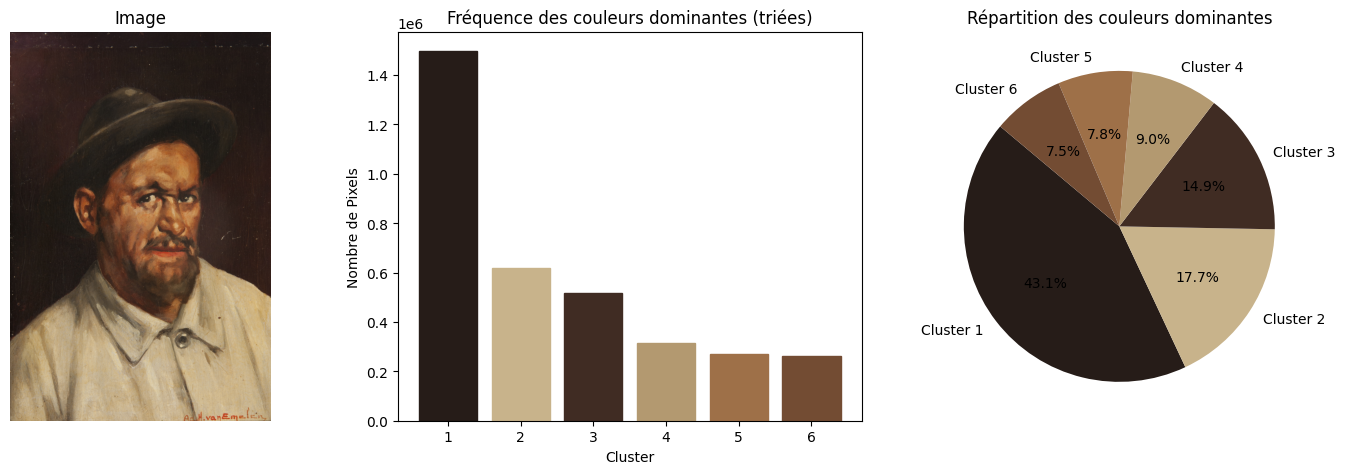

In [ ]:
import PIL

image_files = os.listdir(IMAGES_DIR)
random_index = np.random.randint(len(image_files) - 1)

for index, image_file in enumerate(os.listdir(IMAGES_DIR)):
  try:
    # open the image file
    image_path = os.path.join(IMAGES_DIR, image_file)
    image = PIL.Image.open(image_path)

    # perform the colors extraction from the image
    image_np = np.array(image)
    pixels = preprocess_image(image_np)
    dominant_colors, labels = get_dominant_colors(pixels, 6)

    # save the dominant colors into the image's metadata file
    json_metadata_filepath = os.path.join(IMAGES_METADATA_DIR, os.path.splitext(image_file)[0] + '.json')
    add_json_key_value(json_metadata_filepath, 'colors', dominant_colors.tolist())

    # pick a random image then plot some graphics
    if index == 1:
      # prepare a plot grid with 3 columns and 1 row
      fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

      # show image in the first row
      axes[0].imshow(image)
      axes[0].axis('off')  # deactivate axis
      axes[0].set_title('Image')

      # show histogram in the second column
      npbins = np.arange(0, len(dominant_colors) + 1)
      histogram, _ = np.histogram(labels, bins=npbins)
      sorted_idx = np.argsort(histogram)[::-1]
      sorted_colors = np.array(dominant_colors)[sorted_idx]
      sorted_counts = histogram[sorted_idx]
      cluster_labels = range(1, len(sorted_colors) + 1)
      barlist = axes[1].bar(cluster_labels, sorted_counts)
      for i, bar in enumerate(barlist):
          if i < len(sorted_colors):
              bar.set_color(sorted_colors[i] / 255)
      axes[1].set_xlabel('Cluster')
      axes[1].set_ylabel('Nombre de Pixels')
      axes[1].set_title('Fréquence des couleurs dominantes (triées)')

      # show pie chart in the third column
      colors = [color / 255 for color in sorted_colors]
      pie_labels = [f'Cluster {i+1}' for i in range(len(sorted_colors))]
      piechart = axes[2].pie(sorted_counts, labels=pie_labels, colors=colors, autopct='%1.1f%%', startangle=140)
      axes[2].set_title('Répartition des couleurs dominantes')

      plt.tight_layout()
      plt.show()

  except Exception as e:
    print(f"Error processing image {image_file}: {e}")

In [ ]:
dfs = []

for file in os.listdir(IMAGES_METADATA_DIR):
    file_path = os.path.join(IMAGES_METADATA_DIR, file)
    data = pd.read_json(file_path, lines=True)
    dfs.append(data)

paintings_metadata_df = pd.concat(dfs, ignore_index=True)
paintings_metadata_df

,Make,Model,DateTimeOriginal,DateTimeDigitized,ExposureBiasValue,MeteringMode,FocalLength,ExposureTime,FNumber,ISOSpeedRatings,filename,size,format,mode,tags,colors
0,Canon,Canon EOS 600D,2013:07:14 13:34:24,2013:07:14 13:34:24,0.000000,5,28.0,0.040000,3.2,400,image_20240311_195431_075860.jpg,"[4078, 2583]",JPEG,RGB,"[Les Chênes d'Apremont, sky, cloud, tree, past...","[[55, 36, 26], [212, 206, 199], [190, 185, 182..."
1,NIKON CORPORATION,NIKON D700,2011:03:25 09:34:40,2011:03:25 09:34:40,0.000000,5,34.0,0.004000,16.0,200,image_20240311_195511_320656.jpg,"[3853, 2422]",JPEG,RGB,"[Salao Nobre Teto, flower, leaf, egg as food, ...","[[231, 220, 208], [214, 196, 178], [170, 140, ..."
2,NIKON CORPORATION,NIKON D700,2011:02:22 14:36:21,2011:02:22 14:36:21,0.000000,5,40.0,0.004000,13.0,200,image_20240311_195509_159803.jpg,"[1489, 2125]",JPEG,RGB,"[Árabe, bird, Arabs, portrait, Adrien Henri Vi...","[[156, 123, 89], [189, 189, 173], [119, 86, 61..."
3,NIKON CORPORATION,NIKON D700,2011:03:25 09:32:32,2011:03:25 09:32:32,0.000000,5,32.0,0.004000,16.0,200,image_20240311_195512_907044.jpg,"[2494, 3684]",JPEG,RGB,"[Sala de Jantar 01, woman, flower, chess, coat...","[[211, 195, 176], [180, 155, 128], [107, 77, 5..."
4,NIKON CORPORATION,NIKON D700,2011:02:22 15:29:27,2011:02:22 15:29:27,0.000000,5,62.0,0.004000,13.0,200,image_20240311_195434_366326.jpg,"[1526, 2280]",JPEG,RGB,"[Homem com Chapéu, Camisa Branca, man, hat, po...","[[179, 153, 112], [38, 28, 24], [200, 179, 139..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Canon,Canon EOS 5D Mark II,2017:01:13 11:23:20,2017:01:13 11:23:20,0.000000,5,50.0,0.006250,13.0,100,image_20240311_200820_002674.jpg,"[4000, 2758]",JPEG,RGB,"[La Gloria, Rio de Janeiro, landscape, urban l...","[[243, 239, 233], [175, 163, 128], [77, 67, 54..."
118,SONY,ILCE-6600,2022:01:29 15:58:28,2022:01:29 15:58:28,0.000000,5,23.0,0.025000,3.5,800,image_20240311_200825_348674.jpg,"[2623, 5753]",JPEG,RGB,"[Q111902251, Saint Barbara, Konrad Weiß, Saint...","[[33, 17, 12], [218, 204, 184], [96, 49, 26], ..."
119,Canon,Canon EOS 5D Mark II,2016:06:21 16:28:07,2016:06:21 16:28:07,0.000000,5,85.0,0.005000,9.0,100,image_20240311_200837_121635.jpg,"[3193, 4000]",JPEG,RGB,[Portrait de Sa Majesté l´Impératrice Douarièr...,"[[169, 140, 108], [53, 29, 19], [101, 88, 71],..."
120,Panasonic,DMC-FZ50,2012:04:04 21:52:08,2012:04:04 21:52:08,0.000000,5,17.6,0.076923,3.2,800,image_20240311_200826_774338.JPG,"[3428, 2252]",JPEG,RGB,"[Arctic Sunset, iceberg, sunset, William Bradf...","[[159, 124, 112], [90, 87, 92], [39, 40, 30], ..."


In [ ]:
# Compress images

for filepath in os.listdir(IMAGES_DIR):
  full_path = os.path.join(IMAGES_DIR, filepath)
  img = PIL.Image.open(full_path)
  img.save(full_path, optimize=True, quality=15)

## Analyse de données

In [5]:
paintings_df = pd.read_csv(os.path.join(DATASETS_DIR, 'paintings_df.csv'))
paintings_metadata_df = pd.read_csv(os.path.join(DATASETS_DIR, 'paintings_metadata_df.csv'))

In [6]:
paths = []
images = [os.path.join(IMAGES_DIR, image) for image in os.listdir(IMAGES_DIR)]
checkboxes = [widgets.Checkbox(value=False, description='Favorite') for _ in range(len(images))]

# Create the GridspecLayout widget
layout = GridspecLayout(n_columns=2, n_rows=len(images), width='400px')
for i, (img, checkbox) in enumerate(zip(images, checkboxes)):
  with open(img, "rb") as file:
    image = file.read()
  image_widget = widgets.Image(value=image, format='jpg', width=100, height=100)
  layout[i, 0] = image_widget
  layout[i, 1] = checkbox

# Button to get selected images
button = widgets.Button(description="Select")

# Output widget to display selected images
output = widgets.Output()

# Function to get selected images
def get_selected_images(btn):
  global paths
  paths = []
  selected_paths = [images[i] for i, checkbox in enumerate(checkboxes) if checkbox.value]
  with output:
    output.clear_output()
    print("Selected Images:")
    for path in selected_paths:
      print(path)
      paths.append(path)
  print(paths)

# Link button click event to function
button.on_click(get_selected_images)

# Display the layout and button
display(layout, button, output)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

Button(description='Select', style=ButtonStyle())

Output()

In [ ]:
# save current user image preferences

user_id = 1
preferences_data = []

for image_path in paths:
    preferences_data.append({'user_id': user_id, 'favorite_image_path': image_path})

# generate random preferences samples for fictive users

for i in range(2, 5):
  num_images = random.randint(1, 10)
  user_preferences = random.sample(os.listdir(IMAGES_DIR), num_images)
  for image_path in user_preferences:
      preferences_data.append({'user_id': i, 'favorite_image_path': os.path.join(IMAGES_DIR, image_path)})

users_preferences = pd.DataFrame(preferences_data)
users_preferences.to_csv(os.path.join(DATASETS_DIR, 'users_preferences.csv'), index=False)

In [ ]:
users_preferences = pd.read_csv(os.path.join(DATASETS_DIR, 'users_preferences.csv'))

In [ ]:
user_favorites_images = users_preferences.loc[users_preferences['user_id'] == 1]['favorite_image_path'].apply(lambda x: os.path.basename(x))
users_favorites_images_metadata = paintings_metadata_df[paintings_metadata_df['filename'].isin(user_favorites_images)]

Optimal clusters number: 2


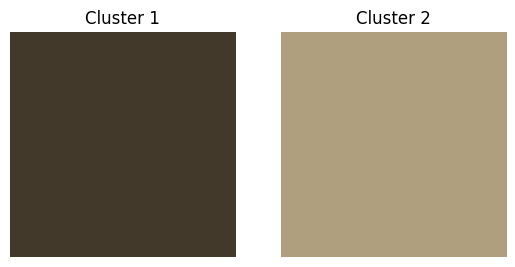

In [ ]:
# Get user favorite colors

favorite_colors = users_favorites_images_metadata['colors']
colors_list = favorite_colors.apply(lambda x: [list(map(float, color)) for color in eval(x)]).tolist()
colors_array = np.array([color for sublist in colors_list for color in sublist])

optimal_n = find_optimal_clusters_number(colors_array)
print('Optimal clusters number: ' + str(optimal_n))
kmeans = KMeans(n_clusters=optimal_n, init='k-means++', n_init='auto')
cluster_labels = kmeans.fit_predict(colors_array)

cluster_centers = kmeans.cluster_centers_

for i, color in enumerate(cluster_centers):
  plt.subplot(1, len(cluster_centers), i + 1)
  plt.imshow([[color / 255]])
  plt.axis('off')
  plt.title(f'Cluster {i + 1}')
plt.show()

In [ ]:
# Get user favorite tags

favorite_tags_list = users_favorites_images_metadata['tags'].apply(eval).tolist()
favorite_tags_flat = [tag for sublist in favorite_tags_list for tag in sublist]

from collections import Counter

favorite_tags_counter = Counter(favorite_tags_flat)
most_common_tags = [(tag, count) for tag, count in favorite_tags_counter.items() if count > 1]
for tag, count in most_common_tags:
    print(f"Tag: {tag}, Frequency: {count}")

Tag: portrait, Frequency: 3


In [ ]:
# Get user favorite creator

favorite_creator = users_favorites_images_metadata['creator']

# Calculer la fréquence de chaque créateur dans les favoris de l'utilisateur
creator_frequency = Counter(favorite_creator)

# Trouver le créateur le plus fréquent
most_common_creator = creator_frequency.most_common(1)[0]
print(most_common_creator[0])

Adrien Henri Vital van Emelen


In [ ]:
# Get user favorite genre

favorite_genre = users_favorites_images_metadata['genre']

# Calculer la fréquence de chaque genre dans les favoris de l'utilisateur
genre_frequency = Counter(favorite_genre)

# Trouver le genre le plus fréquent
most_common_genre = genre_frequency.most_common(1)[0]
print(most_common_genre[0])

portrait


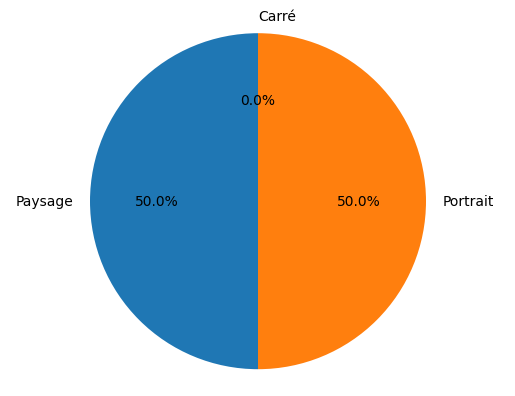

In [ ]:
# Get user favorite orientation

favorite_size = users_favorites_images_metadata['size']
size_list = favorite_size.apply(lambda x: ast.literal_eval(x))
size_array = np.array(size_list.tolist())

nb_paysage = 0
nb_portrait = 0
nb_carre = 0

# Identification de l'orientation et comptage des occurrences
for ele in size_array:
  if ele[0] > ele[1] :
    nb_paysage +=1
  elif ele[0] < ele[1]:
    nb_portrait += 1
  else:
    nb_carre += 1

# Calcul des proportions
proportion_paysage = nb_paysage / len(favorite_size)
proportion_portrait = nb_portrait / len(favorite_size)
proportion_carre = nb_carre / len(favorite_size)

sizes = [proportion_paysage*100, proportion_portrait*100,proportion_carre*100]

# Étiquettes pour chaque part
labels = ['Paysage', 'Portrait', 'Carré']

# Création du diagramme circulaire
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Assure que le diagramme est dessiné comme un cercle.
plt.axis('equal')

plt.show()



## Visualisation des données

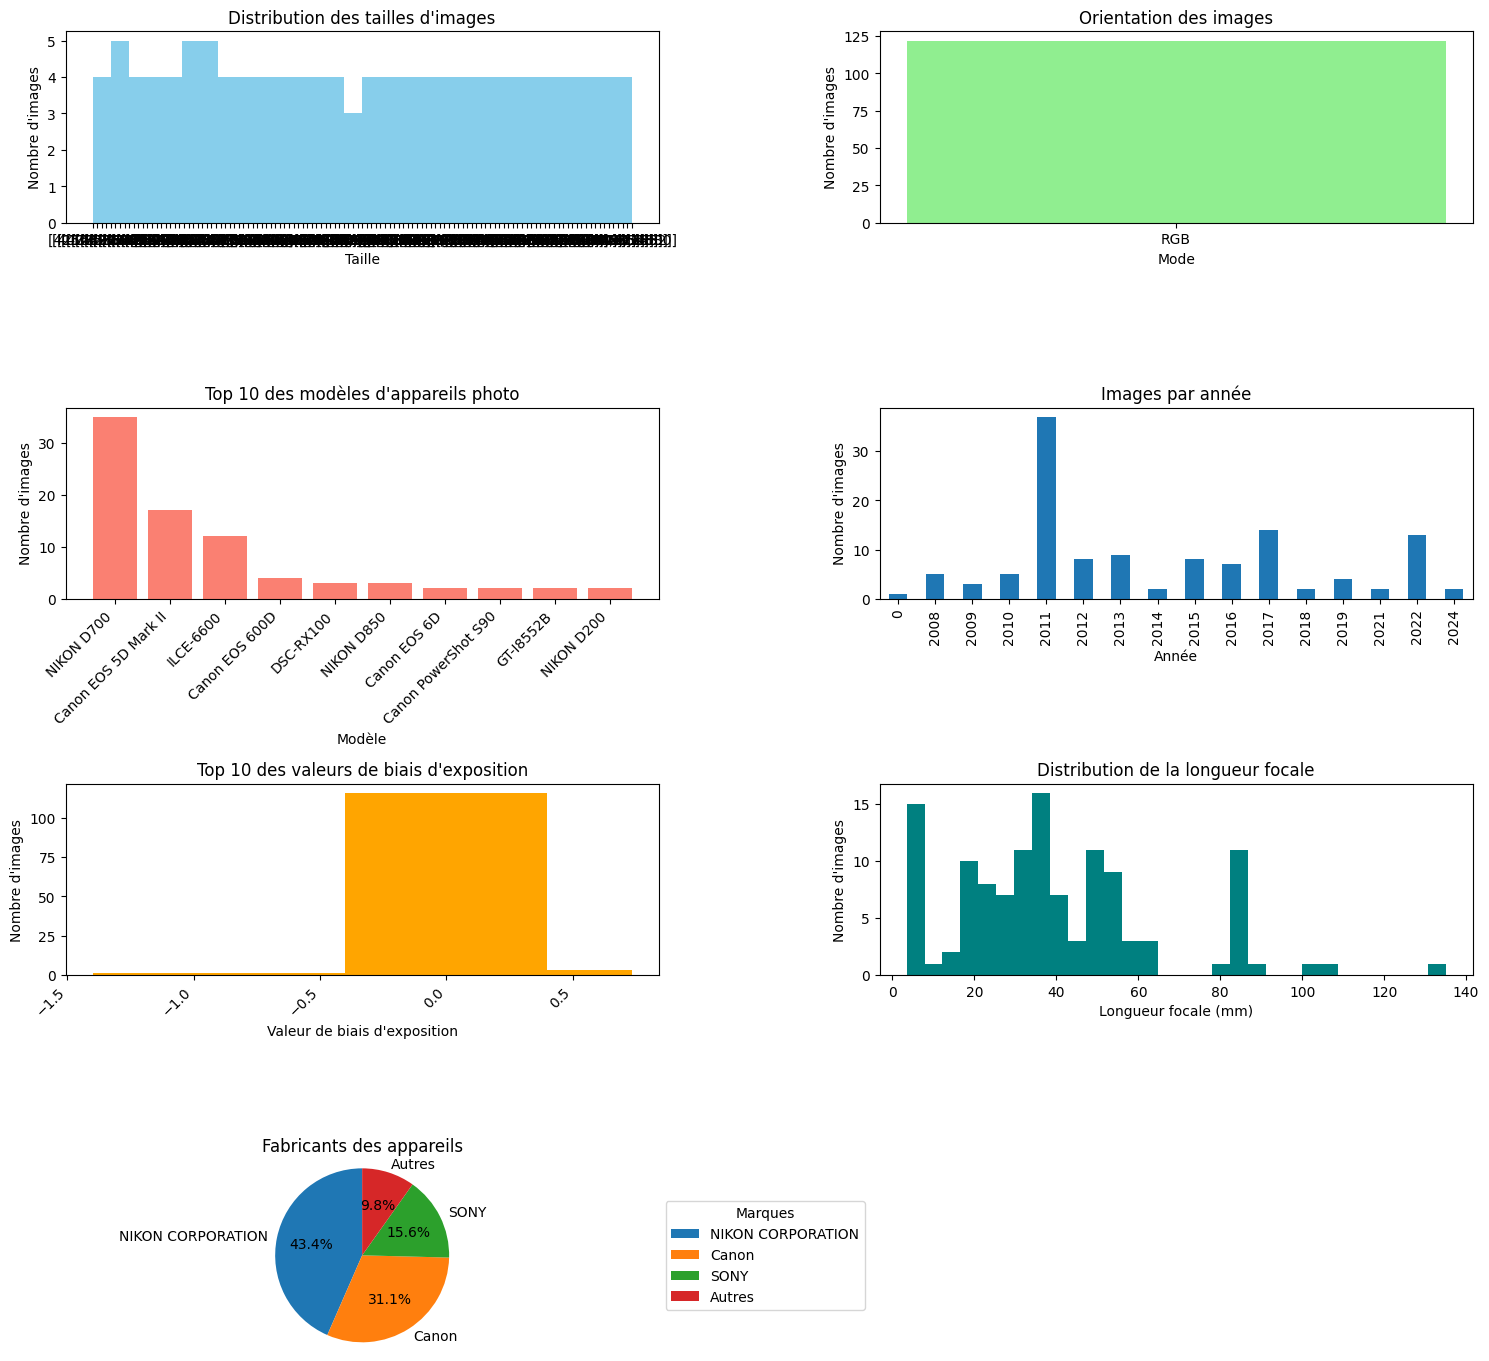

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(15, 25))

# Image size
plt.subplot(7, 2, 1)
plt.hist(paintings_metadata_df['size'], bins=30, color='skyblue')
plt.title('Distribution des tailles d\'images')
plt.xlabel('Taille')
plt.ylabel('Nombre d\'images')

# Image mode
plt.subplot(7, 2, 2)
modes = paintings_metadata_df['mode'].value_counts()
plt.bar(modes.index, modes.values, color='lightgreen')
plt.title('Orientation des images')
plt.xlabel('Mode')
plt.ylabel('Nombre d\'images')

# Image camera model
plt.subplot(7, 2, 3)
models = paintings_metadata_df['Model'].value_counts().head(10)  # Afficher les 10 modèles les plus fréquents
plt.bar(models.index, models.values, color='salmon')
plt.title('Top 10 des modèles d\'appareils photo')
plt.xlabel('Modèle')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=45, ha='right')

# Image DateTimeOriginal
plt.subplot(7, 2, 4)
paintings_metadata_df['Year'] = paintings_metadata_df['DateTimeOriginal'].apply(lambda x: int(x.split(':')[0]) if pd.notnull(x) else None)
images_per_year = paintings_metadata_df['Year'].value_counts().sort_index()
images_per_year.plot(kind='bar')
plt.title('Images par année')
plt.xlabel('Année')
plt.ylabel('Nombre d\'images')

# Image Exposition Bias Value
plt.subplot(7, 2, 5)
bias_values = paintings_metadata_df['ExposureBiasValue'].value_counts().head(10)  # Afficher les 10 valeurs les plus fréquentes
plt.bar(bias_values.index, bias_values.values, color='orange')
plt.title('Top 10 des valeurs de biais d\'exposition')
plt.xlabel('Valeur de biais d\'exposition')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=45, ha='right')

# Image FocalLength
plt.subplot(7, 2, 6)
plt.hist(paintings_metadata_df['FocalLength'].dropna(), bins=30, color='teal')
plt.title('Distribution de la longueur focale')
plt.xlabel('Longueur focale (mm)')
plt.ylabel('Nombre d\'images')

# Image FocalLength
# Calculer les comptes et pourcentages pour chaque marque
model_counts = paintings_metadata_df['Make'].value_counts()
model_percentages = model_counts / model_counts.sum()
# Seuil pour considérer qu'une valeur est trop petite,  10%
threshold = 0.1
# Initialiser les listes pour les valeurs regroupées et les labels
grouped_values = []
grouped_labels = []
# Variable pour stocker la somme des petites valeurs
others_sum = 0
# Regrouper les valeurs
for label, percentage in model_percentages.items():
    if percentage > threshold:
        grouped_values.append(model_counts[label])
        grouped_labels.append(label)
    else:
        others_sum += model_counts[label]
# Ajouter "Autres"
if others_sum > 0:
    grouped_values.append(others_sum)
    grouped_labels.append('Autres')
# Création du diagramme circulaire
plt.subplot(7, 2, 7)
plt.pie(grouped_values, labels=grouped_labels, autopct='%1.1f%%', startangle=90)
plt.title('Fabricants des appareils')
# Ajouter une légende
plt.legend(grouped_labels, title="Marques", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')

plt.tight_layout()
plt.show()

## Recommandation

In [ ]:
def closest_colour(requested_colour):
  """
  Returns the closest requested color name.

  https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python
  """
  min_colours = {}
  for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
    r_c, g_c, b_c = webcolors.hex_to_rgb(key)
    rd = (r_c - requested_colour[0]) ** 2
    gd = (g_c - requested_colour[1]) ** 2
    bd = (b_c - requested_colour[2]) ** 2
    min_colours[(rd + gd + bd)] = name
  return min_colours[min(min_colours.keys())]

In [ ]:
def get_colour_name(requested_colour):
  """
  Get requested color name from a RGB tuple.
  """
  try:
    closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
  except ValueError:
    closest_name = closest_colour(requested_colour)
    actual_name = None
  return actual_name, closest_name

In [ ]:
def size_to_label(dimensions):
  """
  Transform a size array to a categorical size name
  """
  dim = eval(dimensions)
  width, height = dim[0], dim[1]
  if width * height < 2000000:
    return "small"
  elif width * height < 4000000:
    return "medium"
  else:
    return "large"

In [ ]:
def size_to_orientation(dimensions):
  """
  Transform a size array to a categorical orientation name
  """
  dim = eval(dimensions)
  width, height = dim[0], dim[1]
  if width > height:
    return "landscape"
  else:
    return "portrait"

In [ ]:
def color_to_name(colors):
  """
  Transform a colors array of RGB tuples to a categorical colors array
  """
  col = eval(colors)
  color_names = []
  for color in col:
    _, closest_name = get_colour_name(color)
    color_names.append(closest_name)
  return color_names

In [ ]:
def preprocess_dataframe(df):
  # make a copy to avoid modifying the original dataframe
  df_copy = df.copy()

  # remove useless columns for training our model
  df_copy.drop(columns=['DateTimeOriginal', 'DateTimeDigitized', 'filename'], inplace=True)

  # transform mixed columns into categorical columns
  df_copy['size_label'] = df_copy['size'].apply(size_to_label)
  df_copy['orientation'] = df_copy['size'].apply(size_to_orientation)
  df_copy['colors'] = df_copy['colors'].apply(color_to_name)

  # cleaning the final dataframe
  df_copy.drop(columns=['size'], inplace=True)
  df_copy.rename(columns={'size_label': 'size'}, inplace=True)

  return df_copy

In [ ]:
# Preprocessing metadata dataframe

model_df = preprocess_dataframe(paintings_metadata_df)
model_df

,Make,Model,ExposureBiasValue,MeteringMode,FocalLength,ExposureTime,FNumber,ISOSpeedRatings,format,mode,colors,creator,country,genre,tags,Year,size,orientation
0,NIKON CORPORATION,NIKON D700,0.333333,5,24.00,0.005000,6.3,200,JPEG,RGB,"[tan, sienna, whitesmoke, rosybrown, lightgray...",José Wasth Rodrigues,Brazil,history painting,['coat of arms'],2011,large,landscape
1,Canon,Canon EOS 600D,0.000000,5,28.00,0.040000,3.2,400,JPEG,RGB,"[darkslategray, lightgray, silver, darkolivegr...",Théodore Rousseau,France,landscape art,"['sky', 'cloud', 'tree', 'pasture', 'puddle', ...",2013,large,landscape
2,NIKON CORPORATION,NIKON D700,0.000000,5,62.00,0.004000,13.0,200,JPEG,RGB,"[darkkhaki, black, tan, saddlebrown, sienna, d...",Adrien Henri Vital van Emelen,Brazil,portrait,"['man', 'hat', 'portrait']",2011,medium,portrait
3,SONY,DSC-H55,0.000000,5,4.66,0.100000,3.5,400,JPEG,RGB,"[black, gray, darkolivegreen, darkkhaki, dimgr...",Frederic Edwin Church,United States of America,landscape art,['Niagara Falls'],2012,large,landscape
4,NIKON CORPORATION,NIKON D700,0.000000,5,40.00,0.004000,13.0,200,JPEG,RGB,"[gray, silver, darkolivegreen, rosybrown, dark...",Adrien Henri Vital van Emelen,Brazil,history painting,"['bird', 'Arabs', 'portrait']",2011,medium,portrait
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,NIKON CORPORATION,NIKON D700,0.000000,5,45.00,0.004000,13.0,200,JPEG,RGB,"[tan, darkolivegreen, darkkhaki, darkolivegree...",Adrien Henri Vital van Emelen,Brazil,history painting,"['man', 'hat', 'portrait', 'suit', 'negro']",2011,medium,landscape
118,Canon,Canon EOS 5D Mark II,0.000000,5,50.00,0.006250,13.0,100,JPEG,RGB,"[linen, rosybrown, darkslategray, gainsboro, d...",Jules Marie Vincent de Sinety,Brazil,landscape art,"['Rio de Janeiro', 'landscape', 'urban landsca...",2017,large,landscape
119,SONY,ILCE-6600,0.000000,5,23.00,0.025000,3.5,800,JPEG,RGB,"[black, lightgray, saddlebrown, rosybrown, per...",Konrad Weiß,Holy Roman Empire,religious art,['Saint Barbara'],2022,large,portrait
120,Panasonic,DMC-FZ50,0.000000,5,17.60,0.076923,3.2,800,JPEG,RGB,"[gray, dimgray, darkslategray, rosybrown, dimg...",William Bradford,United States of America,landscape art,"['iceberg', 'sunset']",2012,large,landscape


In [ ]:
# Train our recommandation model with all available images metadata

# register some model features by type
numeric_features = ["ExposureBiasValue", "MeteringMode", "FocalLength", "ExposureTime", "FNumber", "ISOSpeedRatings"]
categorical_features = ["Make", "Model", "format", "mode", "creator", "country", "genre", "size", "orientation"]

# make colors and tags list exploitable (little hack)
model_df['colors'] = model_df['colors'].apply(lambda x: [x] if isinstance(x, str) else x)
model_df['tags'] = model_df['tags'].apply(ast.literal_eval)

# use a MultiLabelBinarizer to encode tags
mlb_tags = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb_tags.fit_transform(model_df['tags']), columns=[f'tag_{tag}' for tag in mlb_tags.classes_], index=model_df.index)
model_df.drop(columns=['tags'], inplace=True)
print("tags_encoded.shape: " + str(tags_encoded.shape))

# use a MultiLabelBinarizer to encode colors
mlb_colors = MultiLabelBinarizer()
colors_encoded = pd.DataFrame(mlb_colors.fit_transform(model_df['colors']), columns=[f'color_{color}' for color in mlb_colors.classes_], index=model_df.index)
model_df.drop(columns=['colors'], inplace=True)
print("colors_encoded.shape: " + str(colors_encoded.shape))

# concatenate our dataframe with encoded tags and colors over axis 1
model_df = pd.concat([model_df, tags_encoded, colors_encoded], axis=1)
print(model_df.head())

# initialize transformers to transform the different features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# use a column transformer to handler our heterogenous dataset
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# build the preprocessed dataframe
X_preprocessed = preprocessor.fit_transform(model_df)

print(X_preprocessed.shape)

tags_encoded.shape: (122, 312)
colors_encoded.shape: (122, 41)
                Make           Model  ExposureBiasValue  MeteringMode  \
0  NIKON CORPORATION      NIKON D700           0.333333             5   
1              Canon  Canon EOS 600D           0.000000             5   
2  NIKON CORPORATION      NIKON D700           0.000000             5   
3               SONY         DSC-H55           0.000000             5   
4  NIKON CORPORATION      NIKON D700           0.000000             5   

   FocalLength  ExposureTime  FNumber  ISOSpeedRatings format mode  ...  \
0        24.00         0.005      6.3              200   JPEG  RGB  ...   
1        28.00         0.040      3.2              400   JPEG  RGB  ...   
2        62.00         0.004     13.0              200   JPEG  RGB  ...   
3         4.66         0.100      3.5              400   JPEG  RGB  ...   
4        40.00         0.004     13.0              200   JPEG  RGB  ...   

  color_saddlebrown color_sandybrown color_sien

In [ ]:
# Training our clustering recommandation model

# find the optimal clusters number using silhouette method
optimal_clusters_number = find_optimal_clusters_number(X_preprocessed)
print('Optimal clusters number: ' + str(optimal_clusters_number))

# train the KMeans model using k-means++ init strategy
kmeans = KMeans(n_clusters=optimal_clusters_number, init='k-means++', n_init='auto')
clusters = kmeans.fit_predict(X_preprocessed)

# append a cluster column to our dataframe
model_df["cluster"] = clusters

Optimal clusters number: 9


In [ ]:
# Building the preprocessed interaction

def recommend_items(cluster, data_with_clusters):
  items_in_cluster = data_with_clusters[data_with_clusters["cluster"] == cluster]
  recommended_items = items_in_cluster.sample(n=3)
  return recommended_items

# get the first user's favorite image metadata as a Dataframe
user_interaction = users_favorites_images_metadata.iloc[0]
test_df = pd.DataFrame(user_interaction).transpose()

# preprocess the dataframe
test_df = preprocess_dataframe(test_df)

# make colors and tags list exploitable (little hack)
test_df['colors'] = test_df['colors'].apply(lambda x: [x] if isinstance(x, str) else x)
test_df['tags'] = test_df['tags'].apply(ast.literal_eval)

# use the same MultiLabelBinarizer than the previous step to encode tags
tags_encoded = pd.DataFrame(mlb_tags.transform(test_df['tags']), columns=[f'tag_{tag}' for tag in mlb_tags.classes_], index=test_df.index)
test_df.drop(columns=['tags'], inplace=True)
print("tags_encoded.shape: " + str(tags_encoded.shape))

# use the same MultiLabelBinarizer than the previous step to encode colors
colors_encoded = pd.DataFrame(mlb_colors.transform(test_df['colors']), columns=[f'color_{color}' for color in mlb_colors.classes_], index=test_df.index)
test_df.drop(columns=['colors'], inplace=True)
print("colors_encoded.shape: " + str(colors_encoded.shape))

# concatenate our dataframe with encoded tags and colors over axis 1
test_df = pd.concat([test_df, tags_encoded, colors_encoded], axis=1)

print(test_df.head())
print(test_df.shape)

# creating the preprocessed interaction
preprocessed_interaction = preprocessor.transform(test_df)

tags_encoded.shape: (1, 312)
colors_encoded.shape: (1, 41)
        Make      Model ExposureBiasValue MeteringMode FocalLength  \
108  SAMSUNG  GT-I8552B               0.0            2        3.43   

    ExposureTime FNumber ISOSpeedRatings format mode  ... color_saddlebrown  \
108     0.111111     2.7             200   JPEG  RGB  ...                 0   

    color_sandybrown color_sienna color_silver color_slategray color_tan  \
108                0            0            0               0         0   

     color_thistle  color_wheat  color_white  color_whitesmoke  
108              0            1            0                 0  

[1 rows x 369 columns]
(1, 369)


In [ ]:
# Making recomandations with the clustering trained model

cluster = kmeans.predict(preprocessed_interaction)
recommendations = recommend_items(cluster[0], model_df)
print("Recommended items:")
print(recommendations.index)

Recommended items:
Int64Index([67, 56, 39], dtype='int64')
<class 'pandas.core.frame.DataFrame'>
                 Make        Model  ExposureBiasValue  MeteringMode  \
67  NIKON CORPORATION   NIKON D700           0.333333             2   
56  NIKON CORPORATION  NIKON D3200           0.000000             2   
39  NIKON CORPORATION   NIKON D300           0.000000             3   

    FocalLength  ExposureTime  FNumber  ISOSpeedRatings format mode  ...  \
67         50.0       0.00400     16.0              100   JPEG  RGB  ...   
56         45.0       0.05000      4.8             1600   JPEG  RGB  ...   
39         35.0       0.00625      4.0             1000   JPEG  RGB  ...   

   color_sandybrown color_sienna color_silver  color_slategray color_tan  \
67                0            0            1                0         0   
56                0            1            0                1         0   
39                0            0            0                0         1   

   color

In [ ]:
user_favorites_images = users_preferences.loc[users_preferences['user_id'] == 3]['favorite_image_path'].apply(lambda x: os.path.basename(x)).to_list()
result = ['Favorite' if filename in user_favorites_images else 'NotFavorite' for filename in paintings_metadata_df['filename']]

X = X_preprocessed
print(X_preprocessed.shape)
y = result

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression classifier
classifier = svm.SVC()
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Sample prediction
prediction = classifier.predict(preprocessed_interaction)[0]
print(f"Prediction for the sample item: {prediction}")

(122, 182)
Accuracy: 1.0
Prediction for the sample item: NotFavorite


In [ ]:
image_filename = paintings_df.loc[recommendations.index, 'image_filename']
image_name = paintings_df.loc[recommendations.index, 'painting']

# Filtrer images_full_path pour garder uniquement ceux qui correspondent à image_filename
filtered_images_paths = [os.path.join(IMAGES_DIR, fname) for fname in image_filename if os.path.exists(os.path.join(IMAGES_DIR, fname))]

image_metadata = paintings_metadata_df[paintings_metadata_df['filename'].isin(image_filename)]


layout = GridspecLayout(n_columns=5, n_rows=len(filtered_images_paths), width='100%'
)
for i, (img_path, img_name) in enumerate(zip(filtered_images_paths, image_name)):
    with open(img_path, "rb") as file:
        image = file.read()

    metadata = image_metadata.loc[image_metadata['filename'] == os.path.basename(img_path)]
    if not metadata.empty:
        metadata_text = f"Créateur: {metadata['creator'].iloc[0]}<br>Pays: {metadata['country'].iloc[0]}<br>Genre: {metadata['genre'].iloc[0]}"
        colors_str = metadata['colors'].iloc[0]
        colors = ast.literal_eval(colors_str)

        # Utiliser un Output widget pour capturer l'affichage de la figure Matplotlib
        colors_output = Output()
        with colors_output:
            n_colors = len(colors)
            fig, axs = plt.subplots(1, n_colors, figsize=(n_colors, 1))
            if n_colors == 1:
                axs = [axs]
            for j, color in enumerate(colors):
                axs[j].imshow([[color / np.array(255)]])
                axs[j].axis('off')
            plt.close(fig)  # Fermer la figure pour éviter l'affichage double
            display(fig)  # Afficher la figure dans le Output widget
    else:
        metadata_text = "Metadata not found"
        colors_output = Output()  # Un Output widget vide pour maintenir la structure

    image_widget = Image(value=image, format='jpg', width=100, height=100)
    name_widget = HTML(value=f"<b>{img_name}</b>")
    metadata_widget = HTML(value=metadata_text)

    # Ajouter les widgets au layout
    layout[i, 0] = image_widget
    layout[i, 1] = name_widget
    layout[i, 2] = metadata_widget
    layout[i, 3] = colors_output  # Ajouter l'Output widget pour les couleurs

display(layout)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…